## Exoplanet Discovery Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.svm import SVC
from tsfresh.feature_extraction import extract_features, EfficientFCParameters, settings
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

sns.set_theme(style="darkgrid")

%matplotlib inline

/home/marina/Desktop/ml projects/exoplanets/venv/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df_train = pd.read_csv("data/exoTrain.csv")

### Exploring the data

In [3]:
df_train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [4]:
df_train['LABEL'].value_counts()

LABEL
1    5050
2      37
Name: count, dtype: int64

In [5]:
train_x = df_train.drop('LABEL', axis=1)
train_y = df_train.LABEL

### Analyzing statistics

In [6]:
mean1 = df_train[train_y == 1].mean(axis=1)   
mean2 = df_train[train_y == 2].mean(axis=1)
median1 = df_train[train_y == 1].median(axis=1)
median2 = df_train[train_y == 2].median(axis=1)
std1 = df_train[train_y == 1].std(axis=1)
std2 = df_train[train_y == 2].std(axis=1)

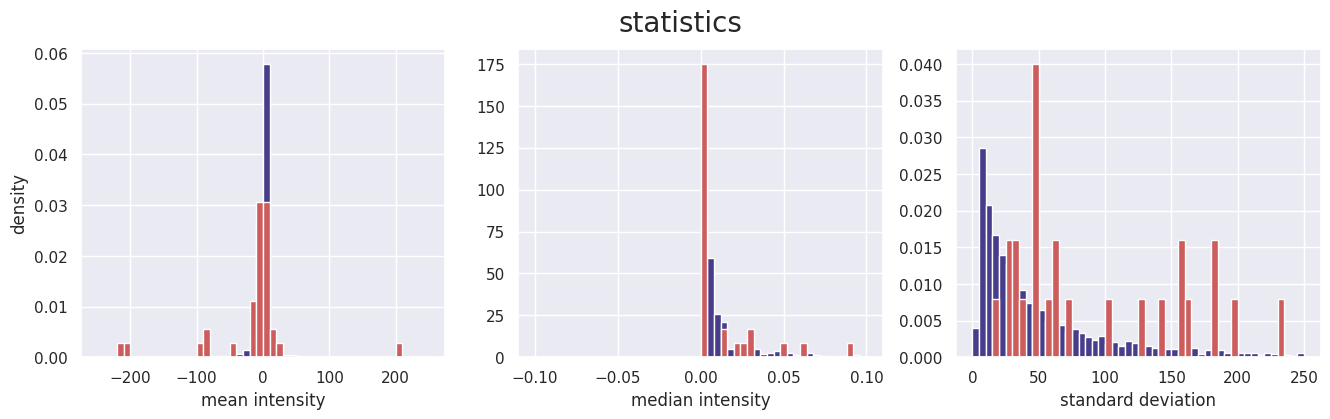

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle("statistics", fontsize=20)

mean1.plot.hist(ax=ax1, color='darkslateblue', bins=50, range=(-250,250), density=True)
mean2.plot.hist(ax=ax1, color='indianred', bins=50, range=(-250,250), density=True)
ax1.set_xlabel('mean intensity')
ax1.set_ylabel('density')

median1.plot.hist(ax=ax2, color='darkslateblue', bins=50, range=(-0.1,0.1), density=True)
median2.plot.hist(ax=ax2, color='indianred', bins=50, range=(-0.1,0.1), density=True)
ax2.set_xlabel('median intensity')
ax2.set_ylabel('')

std1.plot.hist(ax=ax3, color='darkslateblue', bins=50, range=(0,250), density=True)
std2.plot.hist(ax=ax3, color='indianred', bins=50, range=(0,250), density=True)
ax3.set_xlabel('standard deviation')
ax3.set_ylabel('')

plt.show()

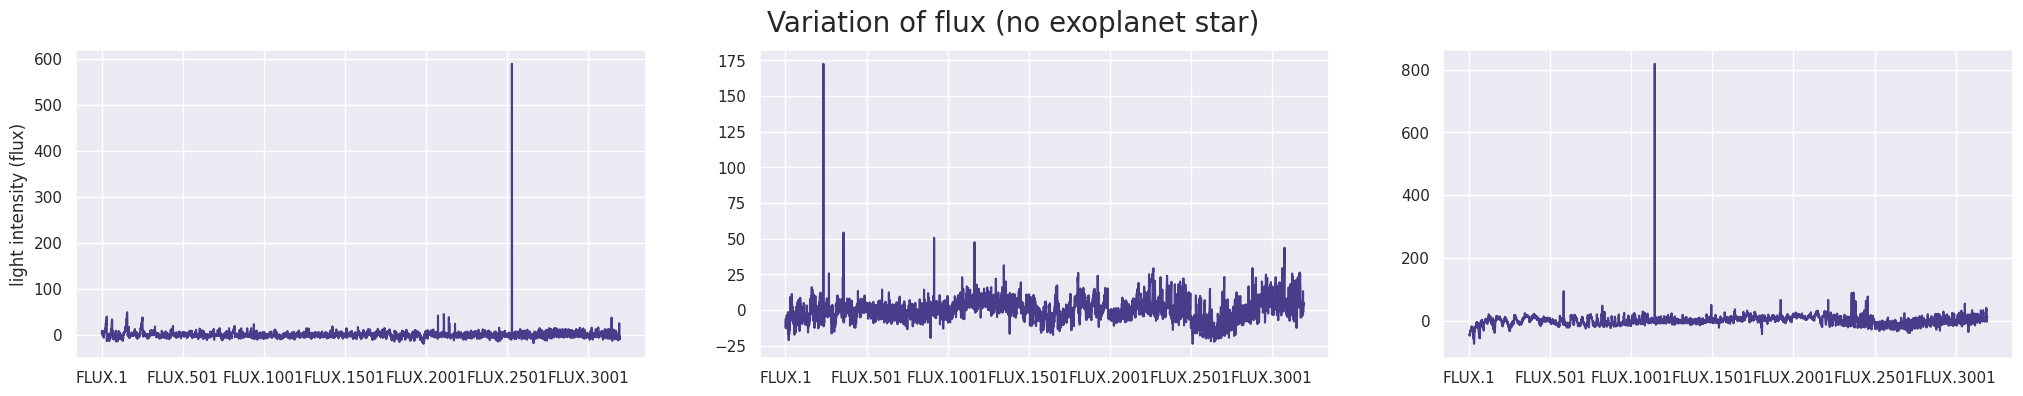

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle("Variation of flux (no exoplanet star)", fontsize=20)

df_train[train_y == 1].sample(1).drop('LABEL', axis=1).transpose().plot(ax=ax1, color="darkslateblue", legend=False)
df_train[train_y == 1].sample(1).drop('LABEL', axis=1).transpose().plot(ax=ax2, color="darkslateblue", legend=False)
df_train[train_y == 1].sample(1).drop('LABEL', axis=1).transpose().plot(ax=ax3, color="darkslateblue", legend=False)

ax1.set_ylabel('light intensity (flux)')

plt.show()

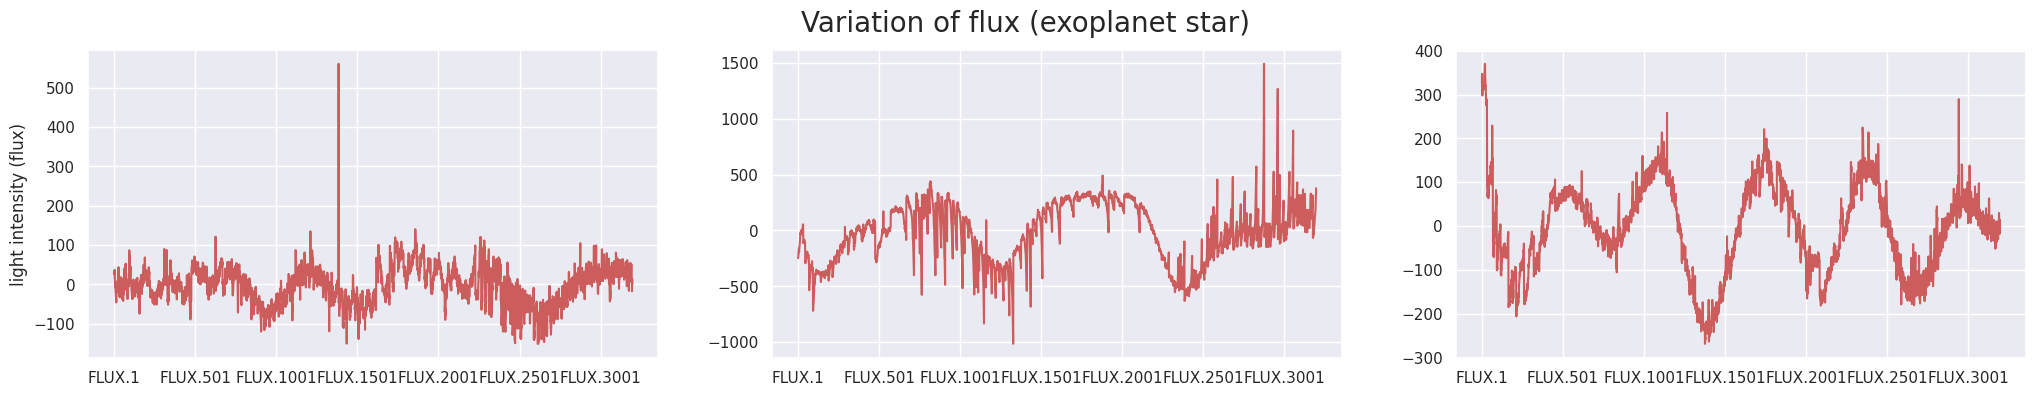

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle("Variation of flux (exoplanet star)", fontsize=20)

df_train[train_y == 2].sample(1).drop('LABEL', axis=1).transpose().plot(ax=ax1, color="indianred", legend=False)
df_train[train_y == 2].sample(1).drop('LABEL', axis=1).transpose().plot(ax=ax2, color="indianred", legend=False)
df_train[train_y == 2].sample(1).drop('LABEL', axis=1).transpose().plot(ax=ax3, color="indianred", legend=False)

ax1.set_ylabel('light intensity (flux)')

plt.show()

### Feature Extraction with tsfresh

Since we are working with time series data, tsfresh was used to extract and calculate several characteristics from it.

In [10]:
ids, times, fluxes = [], [], []
for index, row in train_x.iterrows():
    for time, value in enumerate(row.values):
        ids.append(index)
        times.append(time)
        fluxes.append(value)

In [11]:
assert len(fluxes) == train_x.size

In [12]:
df_ts = pd.DataFrame({'id': ids, 'time': times, 'flux': fluxes})
df_ts

,id,time,flux
0,0,0,93.85
1,0,1,83.81
2,0,2,20.10
3,0,3,-26.98
4,0,4,-39.56
...,...,...,...
16263134,5086,3192,-25.33
16263135,5086,3193,-41.31
16263136,5086,3194,-16.72
16263137,5086,3195,-14.09


In [13]:
#x_tsfresh = extract_features(df_ts, default_fc_parameters=EfficientFCParameters(), column_id="id", column_sort="time") # comment if you want to use precomputed features
x_tsfresh = pd.read_pickle("data/tsfresh.pkl") # uncomment to load precomputed features

In [14]:
x_tsfresh

,flux__variance_larger_than_standard_deviation,flux__has_duplicate_max,flux__has_duplicate_min,flux__has_duplicate,flux__sum_values,flux__abs_energy,flux__mean_abs_change,flux__mean_change,flux__mean_second_derivative_central,flux__median,...,flux__fourier_entropy__bins_2,flux__fourier_entropy__bins_3,flux__fourier_entropy__bins_5,flux__fourier_entropy__bins_10,flux__fourier_entropy__bins_100,flux__permutation_entropy__dimension_3__tau_1,flux__permutation_entropy__dimension_4__tau_1,flux__permutation_entropy__dimension_5__tau_1,flux__permutation_entropy__dimension_6__tau_1,flux__permutation_entropy__dimension_7__tau_1
0,1.0,0.0,0.0,1.0,31822.48,8.288109e+07,56.493889,-0.041737,-0.005412,-0.01,...,0.232478,0.350211,0.592989,0.974684,2.282408,1.748985,3.025798,4.444049,5.889093,6.996325
1,1.0,0.0,0.0,1.0,-23747.10,1.168622e+07,19.963795,0.018401,-0.000175,0.01,...,0.253037,0.393927,0.686898,1.127394,2.499892,1.766859,3.082140,4.570127,6.114366,7.276926
2,1.0,0.0,1.0,1.0,26180.51,2.541505e+08,41.484671,-0.196906,-0.004684,-0.08,...,0.110453,0.209069,0.228465,0.479384,1.317760,1.751397,2.998050,4.357541,5.713135,6.773281
3,1.0,0.0,1.0,1.0,-14855.14,3.413274e+07,13.253667,-0.097791,0.001637,-0.01,...,0.045395,0.045395,0.045395,0.090729,0.588344,1.770221,3.105273,4.600283,6.147807,7.338106
4,1.0,0.0,1.0,1.0,-45527.39,5.303781e+08,51.647137,0.186693,-0.014612,0.02,...,0.045395,0.045395,0.090729,0.200814,1.199151,1.629126,2.735327,3.926411,5.089501,6.004037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1.0,0.0,0.0,1.0,39919.52,1.735884e+07,19.052387,0.034790,0.002678,0.00,...,0.253037,0.393927,0.629031,0.947620,2.241503,1.642067,2.766523,4.001690,5.231253,6.212485
5083,1.0,0.0,0.0,1.0,26986.56,1.397018e+08,70.478739,-0.298551,0.028163,0.00,...,0.291459,0.414158,0.621521,0.939464,2.412004,1.768093,3.080569,4.553883,6.067710,7.190863
5084,1.0,0.0,0.0,1.0,9398.42,1.206593e+07,30.529543,-0.060688,-0.000665,0.00,...,0.326783,0.637375,1.019849,1.701013,3.544038,1.752996,3.056054,4.523606,6.041366,7.225618
5085,1.0,0.0,0.0,1.0,2567.54,3.868573e+05,5.147588,-0.001993,0.000875,0.00,...,0.431351,0.533804,0.892051,1.397184,3.393434,1.791627,3.171727,4.759871,6.447887,7.667580


In [15]:
#impute(x_tsfresh)
#features_filtered = select_features(x_tsfresh, train_y)
features_filtered = pd.read_pickle("data/tsfresh_filtered.pkl")

In [16]:
features_filtered

,flux__median,flux__value_count__value_0,flux__range_count__max_1000000000000.0__min_0,flux__count_above__t_0,flux__number_peaks__n_10,flux__number_peaks__n_5,flux__number_peaks__n_1,flux__number_peaks__n_3,flux__number_peaks__n_50,"flux__fft_coefficient__attr_""abs""__coeff_2",...,"flux__fft_coefficient__attr_""abs""__coeff_42","flux__fft_coefficient__attr_""abs""__coeff_82","flux__fft_coefficient__attr_""real""__coeff_78","flux__fft_coefficient__attr_""abs""__coeff_55",flux__mean_abs_change,flux__absolute_sum_of_changes,"flux__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0","flux__fft_coefficient__attr_""abs""__coeff_71","flux__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","flux__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC"""
0,-0.01,0.0,1598.0,0.499844,118.0,192.0,775.0,290.0,23.0,55671.612807,...,15705.501159,16257.893749,-23501.119609,27909.967986,56.493889,180554.47,56.493889,14254.628456,7.372206e-06,-5.237365
1,0.01,0.0,1599.0,0.500156,121.0,224.0,823.0,337.0,25.0,23034.013754,...,2465.119488,2084.805584,-5886.850412,5994.136280,19.963795,63804.29,19.963795,1748.818813,2.198663e-12,-8.011227
2,-0.08,0.0,1598.0,0.499844,86.0,132.0,753.0,218.0,14.0,41912.294689,...,29462.278261,33000.491883,22503.923891,31858.344701,41.484671,132585.01,41.484671,19790.126501,1.004086e-04,-4.659012
3,-0.01,0.0,1598.0,0.499844,103.0,219.0,846.0,342.0,15.0,33309.457851,...,12103.950698,568.849116,-4941.686308,11549.316906,13.253667,42358.72,13.253667,6698.813388,6.941542e-03,-3.543331
4,0.02,0.0,1599.0,0.500156,119.0,176.0,633.0,240.0,21.0,140433.251401,...,22914.791595,28436.511670,14688.460530,28441.217178,51.647137,165064.25,51.647137,14492.159638,3.808597e-02,-2.967072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0.00,2.0,1599.0,0.500156,142.0,205.0,673.0,284.0,30.0,17293.982241,...,2695.202438,1895.215588,843.831478,3267.017717,19.052387,60891.43,19.052387,13167.398291,5.785540e-05,-4.785943
5083,0.00,1.0,1599.0,0.500156,142.0,229.0,893.0,346.0,28.0,78773.286036,...,47526.842066,42113.016934,-7285.880370,33226.783843,70.478739,225250.05,70.478739,23925.893793,1.105744e-10,-7.334479
5084,0.00,2.0,1600.0,0.500469,154.0,272.0,846.0,368.0,26.0,18216.478909,...,2717.323488,3353.627720,7880.058554,360.792117,30.529543,97572.42,30.529543,1573.241229,5.334566e-18,-10.220694
5085,0.00,2.0,1599.0,0.500156,150.0,271.0,1058.0,438.0,30.0,2780.975139,...,630.351515,786.942846,-53.430862,19.362745,5.147588,16451.69,5.147588,901.291567,7.447478e-23,-12.301090


In [17]:
kind_to_fc_parameters = settings.from_columns(features_filtered)

In [18]:
scaler = StandardScaler()
scaler.fit(features_filtered)
train_x = scaler.transform(features_filtered)

In [19]:
model = HistGradientBoostingClassifier()
parameters= {'max_depth': (6, 8), 'min_samples_leaf': (30, 32), 'l2_regularization': (0, )}
clf = GridSearchCV(model, parameters, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

clf = SVC(kernel="linear")
clf.fit(train_x, train_y)
result = cross_val_score(clf, train_x, train_y)

In [20]:
result.mean()

np.float64(0.9982306680343782)

### Test data

In [21]:
df_test = pd.read_csv("data/exoTest.csv")

In [22]:
df_test.tail()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60
569,1,3071.19,2782.53,2608.69,2325.47,2089.37,1769.56,1421.09,1142.09,902.31,...,695.41,865.97,882.41,1203.06,1293.03,1354.41,-192.81,-277.22,-69.63,121.56


In [23]:
test_x = df_test.drop('LABEL', axis=1)
test_y = df_test.LABEL

In [24]:
df_test['LABEL'].value_counts()

LABEL
1    565
2      5
Name: count, dtype: int64

In [25]:
ids, times, fluxes = [], [], []
for index, row in test_x.iterrows():
    for time, value in enumerate(row.values):
        ids.append(index)
        times.append(time)
        fluxes.append(value)

In [26]:
df_ts_test = pd.DataFrame({'id': ids, 'time': times, 'flux': fluxes})
df_ts_test

,id,time,flux
0,0,0,119.88
1,0,1,100.21
2,0,2,86.46
3,0,3,48.68
4,0,4,46.12
...,...,...,...
1822285,569,3192,1354.41
1822286,569,3193,-192.81
1822287,569,3194,-277.22
1822288,569,3195,-69.63


In [27]:
x_tsfresh_test = extract_features(df_ts_test, kind_to_fc_parameters=kind_to_fc_parameters, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [26:48<00:00, 80.43s/it]  


In [29]:
y_hat = clf.predict(x_tsfresh_test.values)
print(classification_report(test_y, y_hat))

              precision    recall  f1-score   support

           1       1.00      0.01      0.02       565
           2       0.01      1.00      0.02         5

    accuracy                           0.02       570
   macro avg       0.50      0.51      0.02       570
weighted avg       0.99      0.02      0.02       570

